<a href="https://colab.research.google.com/github/tatianamgar/Work_GPN/blob/main/A/B%20test%20preparation_hitrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from pathlib import Path

root_dir = os.path.abspath(os.getcwd())
root_dir = str(Path(root_dir).parent)
sys.path.append(root_dir)


import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import kstest, shapiro
import statsmodels.stats.power as smp
import math
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')



from constants import PATH_AUDIT_SEARCH, PATH_AUDIT_COPY, PATH_AUDIT_CARD
from src.data.make_dataset import read_file
from src.features.build_features import get_layer
from src.utils.statistics import interval, report, sample_size, test_power
# from src.utils.helpers import get_window_df_by_query, get_window_df_by_ans_ids

os.chdir('C:/Users/Mgar.TA/PycharmProjects/analytics-main')

In [ ]:
df = pd.read_csv("C:\Users\Mgar.TA\PycharmProjects\analytics-main\data\raw\nsi.audit_search.csv" , sep='$', encoding='utf-8')
df.head(3)

In [ ]:
# audit_search таблица
search = read_file(PATH_AUDIT_SEARCH, sep='\t')
search = search[['date_time', 'page_number', 'query', 'username', 'answer', 'answer_ids', 'session_id', 'request_id']]
# убираем в audit_search пустые запросы
search = search.dropna()
# добавляем поле слоя поиска
search['activeLayer'] = get_layer(search, 'answer')
search = search[search['date_time'] > '2023-06-06 12:00']
search = search[search['activeLayer'] == 'fulltext']
search = search.drop_duplicates(subset=['request_id'])


# audit_card таблица
card = read_file(PATH_AUDIT_CARD, sep='\t')
card = card[card['date_time'] > '2023-06-06 12:00']
card = card[['username', 'query', 'date_time', 'session_id' , 'request_id']]
card = card.drop_duplicates(subset=['request_id'])




# audit_copy таблица
copy = read_file(PATH_AUDIT_COPY, sep='\t')
copy = copy[copy['date_time'] > '2023-06-06 12:00']
copy = copy[['username', 'query', 'date_time', 'session_id' , 'request_id', 'action']]
copy = copy[(copy['action'] == 'SEARCH_ID') | (copy['action'] == 'SEARCH_DESCRIPTION')]
copy = copy.drop_duplicates(subset=['request_id'])



In [ ]:
cs_hr1 = search.merge(card[['request_id', 'query']], how='left', on=['request_id'])
cs_hr1 = cs_hr1.rename(columns={"query_x": "search_query", 'query_y': 'code_of_opened_card'})

cs_hr = cs_hr1.merge(copy[['request_id', 'action']], how='left', on=['request_id'])
cs_hr.head(3)

,date_time,page_number,search_query,username,answer,answer_ids,session_id,request_id,activeLayer,code_of_opened_card,action
0,2023-06-19 15:37:08.872,1,"*ввгнг(а)-frls*3х1,5*",Oganesov.AN@GAZPROM-NEFT.LOCAL,"{ ""hits"" : [ { ""number"" : 1, ""id"" : ...","[770001013597, 770000845367, 770000901436, 770...",5eaca438-72f7-498b-91cc-8bc8946524b6,9eed5172-929c-4384-88c5-0c5001a0233d,fulltext,7.700009e+11,NaN
1,2023-06-19 15:36:01.225,1,"*ввгнг(а)-ls*3х1,5*",Oganesov.AN@GAZPROM-NEFT.LOCAL,"{ ""hits"" : [ { ""number"" : 1, ""id"" : ...","[770000129619, 770001106440, 770001266991, 770...",5eaca438-72f7-498b-91cc-8bc8946524b6,8fc077e8-2ff8-407a-a9f4-d3b8da613337,fulltext,7.700003e+11,SEARCH_ID
2,2023-06-19 14:34:39.096,1,G310201020102,Enikeev.IR@GAZPROM-NEFT.LOCAL,"{ ""hits"" : [ { ""number"" : 1, ""id"" : ...","[770000401330, 770000401333, 770000335470, 770...",d933b8fe-4f41-4e25-a8cf-10648dda4745,759ae04a-1401-4cef-99f4-2250e3b4b57a,fulltext,NaN,NaN


In [ ]:
# оставляем только последовательность : если в запросе было действие, то в порядке запрос-карточка

# cs_hr1['marker'] = np.nan
# for ind in tqdm(cs_hr1.index):
#     if cs_hr1['code_of_opened_card'][ind] == np.nan:
#         continue

#     else:
#         if cs_hr1['card_time'][ind] < cs_hr1['search_time'][ind]:
#             cs_hr1['marker'][ind] = True


# cs_hr1['marker'].value_counts()

# cs_hr1 = cs_hr1[cs_hr1['marker'] != True]

100%|██████████| 22892/22892 [00:00<00:00, 37166.94it/s]


marker
True    5654
Name: count, dtype: int64

In [ ]:
cs_hr['code_of_opened_card'] = cs_hr['code_of_opened_card'].apply(lambda x: 0 if math.isnan(x) else 1)
cs_hr['action'] = cs_hr['action'].apply(lambda x: 1 if type(x)==str else 0)
cs_hr.head(3)

,date_time,page_number,search_query,username,answer,answer_ids,session_id,request_id,activeLayer,code_of_opened_card,action
0,2023-06-19 15:37:08.872,1,"*ввгнг(а)-frls*3х1,5*",Oganesov.AN@GAZPROM-NEFT.LOCAL,"{ ""hits"" : [ { ""number"" : 1, ""id"" : ...","[770001013597, 770000845367, 770000901436, 770...",5eaca438-72f7-498b-91cc-8bc8946524b6,9eed5172-929c-4384-88c5-0c5001a0233d,fulltext,1,0
1,2023-06-19 15:36:01.225,1,"*ввгнг(а)-ls*3х1,5*",Oganesov.AN@GAZPROM-NEFT.LOCAL,"{ ""hits"" : [ { ""number"" : 1, ""id"" : ...","[770000129619, 770001106440, 770001266991, 770...",5eaca438-72f7-498b-91cc-8bc8946524b6,8fc077e8-2ff8-407a-a9f4-d3b8da613337,fulltext,1,1
2,2023-06-19 14:34:39.096,1,G310201020102,Enikeev.IR@GAZPROM-NEFT.LOCAL,"{ ""hits"" : [ { ""number"" : 1, ""id"" : ...","[770000401330, 770000401333, 770000335470, 770...",d933b8fe-4f41-4e25-a8cf-10648dda4745,759ae04a-1401-4cef-99f4-2250e3b4b57a,fulltext,0,0


In [ ]:
cs_hr['actions'] = np.nan

for ind in tqdm(cs_hr.index):
    if cs_hr['code_of_opened_card'][ind] == 1 or cs_hr['action'][ind] == 1:
        cs_hr['actions'][ind]  = 1

    else:
        cs_hr['actions'][ind]  = 0

100%|██████████| 9765/9765 [00:02<00:00, 4664.20it/s]


In [ ]:
cs_hr['actions'].value_counts()

actions
0.0    5358
1.0    4407
Name: count, dtype: int64

In [ ]:
cs_hr['date'] = cs_hr['date_time'].apply(lambda x: x.date())
hr_per_user = pd.merge(cs_hr.groupby(['username', 'date'])['request_id'].count(),
                       cs_hr.groupby(['username', 'date'])['actions'].sum(),
                       how='inner', on=['username', 'date'])
hr_per_user = hr_per_user.rename(columns={'request_id': 'num_of_queries', 'actions': 'num_of_actions'})
hr_per_user['HR'] = hr_per_user['num_of_actions']/hr_per_user['num_of_queries']
hr_per_user.head(3)

,,num_of_queries,num_of_actions,HR
username,date,,,
Abdrakhmanov.TA@GAZPROM-NEFT.LOCAL,2023-06-15,5,5.0,1.000000
Abdulina.II@GAZPROM-NEFT.LOCAL,2023-06-14,2,2.0,1.000000
Adilov.SSh@GAZPROM-NEFT.LOCAL,2023-06-13,6,2.0,0.333333


In [ ]:
len(hr_per_user[(hr_per_user['HR'] == 1) | (hr_per_user['HR'] == 0)])/len(hr_per_user)

0.3939393939393939

In [ ]:
len(hr_per_user[hr_per_user['HR'] == 1])/len(hr_per_user)

0.19559228650137742

In [ ]:
len(hr_per_user[hr_per_user['HR'] == 0])/len(hr_per_user)

0.19834710743801653

In [ ]:

hr_per_user = hr_per_user[(hr_per_user['HR'] < 1) & (hr_per_user['HR'] > 0)]
hr_per_user['HR'].describe()

count    440.000000
mean       0.468293
std        0.192299
min        0.052632
25%        0.333333
50%        0.500000
75%        0.608135
max        0.911765
Name: HR, dtype: float64

<Axes: >

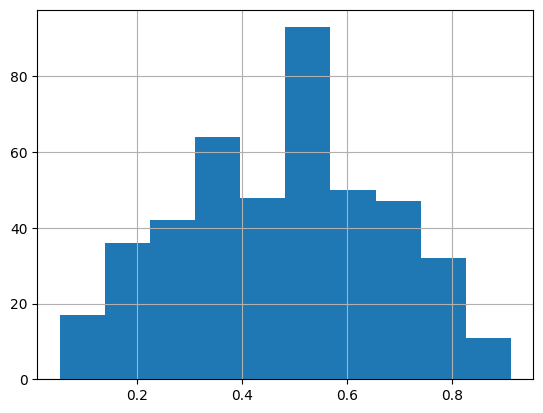

In [ ]:
hr_per_user['HR'].hist()

<Axes: >

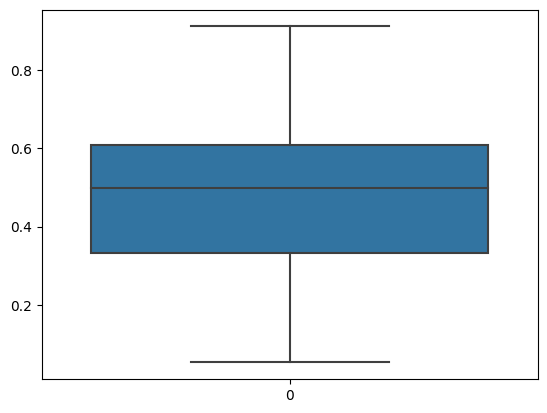

In [ ]:
sns.boxplot(hr_per_user['HR'])

**Тесты на нормальность**

H0- выборка взята из ген сов-ти с нормальным распределением
H1 - выборка взята из ген сов-ти с др распределением

In [ ]:
kstest(hr_per_user['HR'], 'norm')

KstestResult(statistic=0.5261914736406653, pvalue=4.660604254575819e-114, statistic_location=0.1, statistic_sign=-1)

In [ ]:
shapiro(hr_per_user['HR'])

ShapiroResult(statistic=0.983678936958313, pvalue=7.375476707238704e-05)

тесты не показывают стат значимые результаты, H0 отвергнуть нельзя, придерживаемся гипотезы, что распр нормальное

**A/B test**

Т-тест

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power
mean = hr_per_user['HR'].describe()['mean'] # рассчитанное среднее за 2-5 недель
se = hr_per_user['HR'].describe()['std'] # рассчитанное стандартное отклонение за тот же период
power = 0.8
alpha = 0.05
lift = 0.2 # хотим увидеть 20% изменение в метрику
effect_size = mean / se * lift
print(effect_size)

0.4870451819310816


In [ ]:
# Результат – наблюдения на одну выборку (соотвественно, умножаем на 2)
sample_size = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1)
sample_size

67.1496283858968

In [ ]:
effects = []
sample_sizes = []

for i in tqdm(range(50,2000)):
    effects.append(smp.tt_ind_solve_power(nobs1 = i, alpha = alpha, power = power))
    sample_sizes.append(i)

100%|██████████| 1950/1950 [00:08<00:00, 234.07it/s]


Text(0, 0.5, 'Effect Amount')

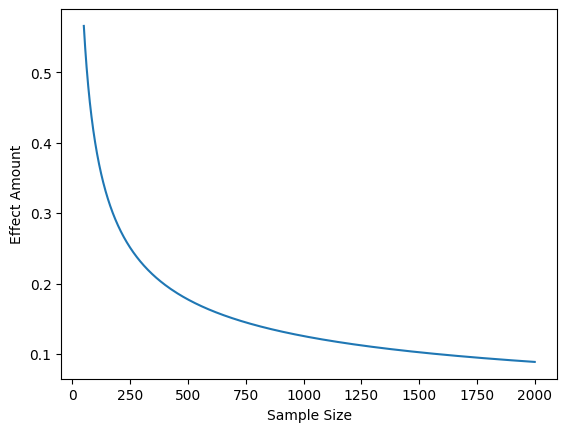

In [ ]:
viz = sns.lineplot(x=sample_sizes, y=effects)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Amount")

In [ ]:
# среднее количество пользователей, совершающих действие, в день
us_day = cs_hr.groupby(['date'])['username'].nunique().agg(['mean'])
test_duration = (sample_size*2)/us_day
working_weeks = test_duration/5
print(f'Длительность теста при детектируемом изменении в { round(lift *100, 2) } %, мощности теста {power} - \n {round(test_duration[0], 0)} дней, \n {round(working_weeks[0], 1)} рабочих недель')

Длительность теста при детектируемом изменении в 20.0 %, мощности теста 0.8 - 
 3.0 дней, 
 0.5 рабочих недель


**Хитрейт общий**

<Axes: >

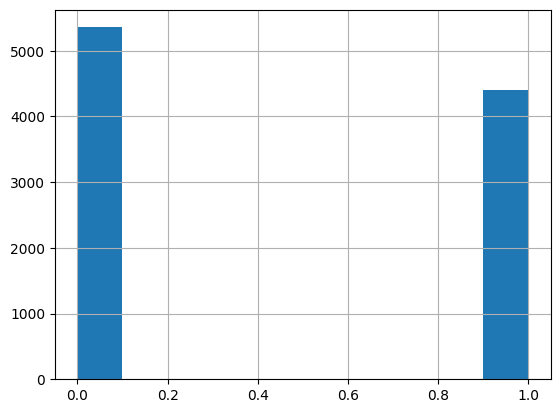

In [ ]:
cs_hr['actions'].hist()

In [ ]:
HR = sum(cs_hr['actions'])/len(cs_hr['actions'])
HR

0.45130568356374806

In [ ]:
cs_hr['actions'].describe()

count    9765.000000
mean        0.451306
std         0.497649
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: actions, dtype: float64

In [ ]:
# Критерий пропорций (нужен для кликов, конверсий). Ниже посчитаем прогноз, в котором мы хотели бы увидеть разницу p_x и p_y.
# Когда подойдет время сравнения экспериментального эффекта с прогнозом, нам таким же образом нужно взять все экспериментальные
# параметры и сравнить их. Например, прогнозный h с фактическим (экспериментальным) h
alpha = 0.05
power = 0.8
n = len(cs_hr['actions'])
p_x = HR
p_y = 0.5412 #20%

h = 2*math.asin(np.sqrt(p_x)) - 2*math.asin(np.sqrt(p_y))
h

-0.18003677358474923

In [ ]:
# Сколько наблюдений необходимо для заданного эффекта, чтобы
# результаты двухвыборочного теста пропорций были с заданным уровнем значимости
# и заданной мощностью критерий (1 - вероятность ошибки II-го рода)

sample_size = smp.zt_ind_solve_power(effect_size = h, alpha = alpha, power = power, alternative='two-sided')
sample_size

484.2996598999949

In [ ]:
effects = []
sample_sizes = []

for i in tqdm(range(50,2000)):
    effects.append(smp.zt_ind_solve_power(nobs1 = i, alpha = alpha, power = power))
    sample_sizes.append(i)

100%|██████████| 1950/1950 [00:11<00:00, 165.93it/s]


Text(0, 0.5, 'Effect Amount')

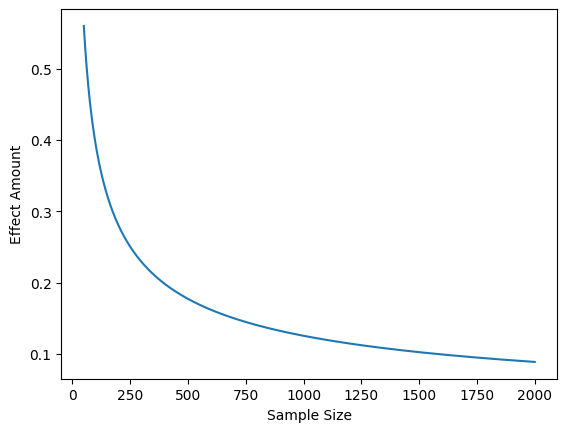

In [ ]:
viz = sns.lineplot(x=sample_sizes, y=effects)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Amount")

Длительность теста:

In [ ]:
# среднее количество пользователей, совершающих действие, в день
us_day = cs_hr.groupby(['date'])['username'].count().agg(['mean'])
test_duration = (sample_size*2)/us_day
working_weeks = test_duration/5
print(f'Длительность теста при детектируемом изменении в { round(h *100, 2) } %, мощности теста {power} - \n {round(test_duration[0], 0)} дней, \n {round(working_weeks[0], 1)} рабочих недель')

Длительность теста при детектируемом изменении в -18.0 %, мощности теста 0.8 - 
 1.0 дней, 
 0.3 рабочих недель


In [ ]:
us_day = cs_hr[cs_hr['actions'] == 1].groupby(['date'])['username'].nunique().agg(['mean'])
us_day

mean    41.571429
Name: username, dtype: float64

In [ ]:
cs_hr.groupby(['date'])['username'].count().agg(['mean'])

mean    697.5
Name: username, dtype: float64

In [ ]:
cs_hr[cs_hr['actions'] == 1].groupby(['date'])['username'].count().agg(['mean'])

mean    314.785714
Name: username, dtype: float64

In [ ]:
cs_hr.groupby(['date'])['username'].nunique().agg(['mean'])

mean    51.857143
Name: username, dtype: float64

Хитрейт в день

In [ ]:
cs_hr['date'] = cs_hr['date_time'].apply(lambda x: x.date())
hr_per_day = pd.merge(cs_hr.groupby(['date'])['request_id'].count(),
                       cs_hr.groupby(['date'])['actions'].sum(),
                       how='inner', on=['date'])
hr_per_day = hr_per_day.rename(columns={'request_id': 'num_of_queries', 'actions': 'num_of_actions'})
hr_per_day['HR'] = hr_per_day['num_of_actions']/hr_per_day['num_of_queries']
hr_per_day.head(3)

,num_of_queries,num_of_actions,HR
date,,,
2023-06-06,121,41.0,0.338843
2023-06-07,606,272.0,0.448845
2023-06-08,1159,551.0,0.475410


<Axes: >

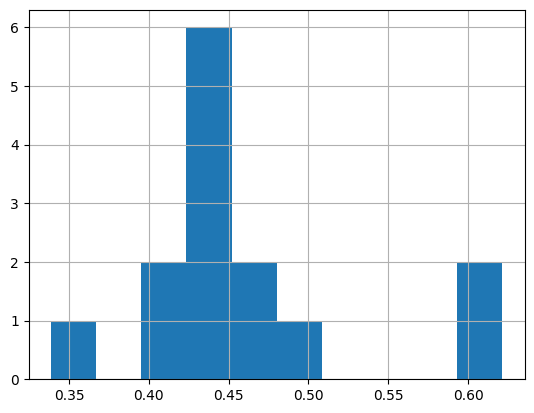

In [ ]:
hr_per_day['HR'].hist()

In [ ]:
kstest(hr_per_day['HR'], 'norm')

KstestResult(statistic=0.632635987597791, pvalue=5.8302262445863946e-06, statistic_location=0.33884297520661155, statistic_sign=-1)

In [ ]:
shapiro(hr_per_day['HR'])

ShapiroResult(statistic=0.8762474656105042, pvalue=0.05140141397714615)

In [ ]:
us_day = cs_hr[cs_hr['actions'] == 1].groupby(['date'])['username'].nunique().agg(['mean'])
us_day

mean    41.571429
Name: username, dtype: float64

Хитрейт на пользователя

In [ ]:
cs_hr['date'] = cs_hr['date_time'].apply(lambda x: x.date())
hr_per = pd.merge(cs_hr.groupby(['username'])['request_id'].count(),
                       cs_hr.groupby(['username'])['actions'].sum(),
                       how='inner', on=['username'])
hr_per = hr_per.rename(columns={'request_id': 'num_of_queries', 'actions': 'num_of_actions'})
hr_per['HR'] = hr_per['num_of_actions']/hr_per['num_of_queries']
hr_per.head(3)

,num_of_queries,num_of_actions,HR
username,,,
Abdrakhmanov.TA@GAZPROM-NEFT.LOCAL,5,5.0,1.000000
Abdulina.II@GAZPROM-NEFT.LOCAL,2,2.0,1.000000
Adilov.SSh@GAZPROM-NEFT.LOCAL,6,2.0,0.333333


<Axes: >

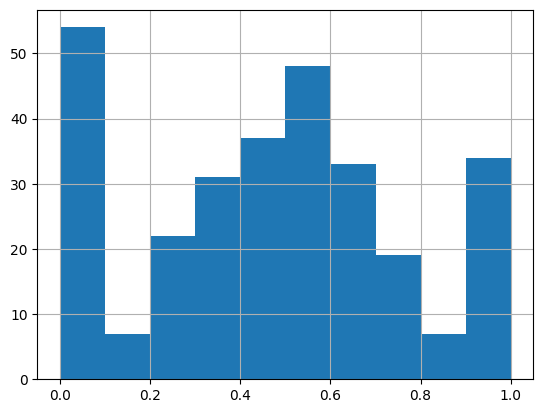

In [ ]:
hr_per['HR'].hist()

In [ ]:
len(hr_per[(hr_per['HR'] == 1) | (hr_per['HR'] == 0)])/len(hr_per)

0.2876712328767123

In [ ]:
hr_per = hr_per[(hr_per['HR'] < 1) & (hr_per['HR'] > 0)]
hr_per['HR'].describe()

count    208.000000
mean       0.488266
std        0.180044
min        0.066667
25%        0.363636
50%        0.500000
75%        0.638346
max        0.923077
Name: HR, dtype: float64

In [ ]:
kstest(hr_per['HR'], 'norm')

KstestResult(statistic=0.5373376787647498, pvalue=1.0834390866677559e-56, statistic_location=0.16666666666666666, statistic_sign=-1)

In [ ]:
shapiro(hr_per['HR'])

ShapiroResult(statistic=0.9878333806991577, pvalue=0.073094442486763)

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power
mean = hr_per['HR'].describe()['mean'] # рассчитанное среднее за 2-5 недель
se = hr_per['HR'].describe()['std'] # рассчитанное стандартное отклонение за тот же период
power = 0.8
alpha = 0.05
lift = 0.2 # хотим увидеть 20% изменение в метрику
effect_size = mean / se * lift
print(effect_size)

0.5423859958199313


In [ ]:
# Результат – наблюдения на одну выборку (соотвественно, умножаем на 2)
sample_size = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1)
sample_size

54.33772660371254

In [ ]:
# среднее количество пользователей, совершающих действие, в день
us_day = cs_hr.groupby(['username'])['request_id'].count().agg(['mean'])
test_duration = (sample_size*2)/us_day
working_weeks = test_duration/5
print(f'Длительность теста при детектируемом изменении в { round(lift *100, 2) } %, мощности теста {power} - \n {round(test_duration[0], 0)} дней, \n {round(working_weeks[0], 1)} рабочих недель')

Длительность теста при детектируемом изменении в 20.0 %, мощности теста 0.8 - 
 3.0 дней, 
 0.6 рабочих недель


In [ ]:
effects = []
sample_sizes = []

for i in tqdm(range(50,2000)):
    effects.append(smp.tt_ind_solve_power(nobs1 = i, alpha = alpha, power = power))
    sample_sizes.append(i)

100%|██████████| 1950/1950 [00:08<00:00, 231.54it/s]


Text(0, 0.5, 'Effect Amount')

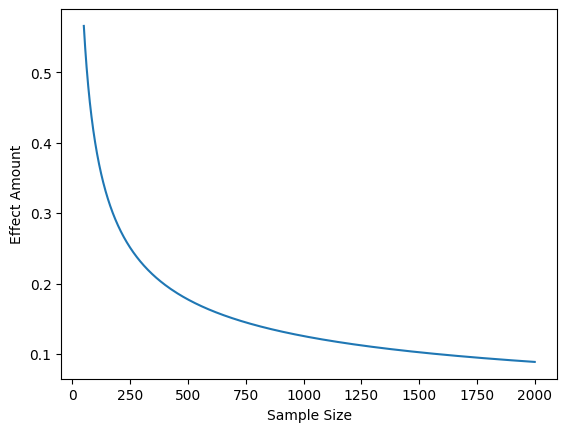

In [ ]:
viz = sns.lineplot(x=sample_sizes, y=effects)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Amount")

In [ ]:
hr_per = hr_per[(hr_per['HR'] < 1) & (hr_per['HR'] > 0)]
hr_per['HR'].describe()

count    208.000000
mean       0.488266
std        0.180044
min        0.066667
25%        0.363636
50%        0.500000
75%        0.638346
max        0.923077
Name: HR, dtype: float64

In [ ]:
effects = []
sample_sizes = []

for i in tqdm(range(50,2000)):
    effects.append(smp.zt_ind_solve_power(nobs1 = i, alpha = alpha, power = power))
    sample_sizes.append(i)
viz = sns.lineplot(x=sample_sizes, y=effects)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Amount")
hr_per = hr_per[(hr_per['HR'] < 1) & (hr_per['HR'] > 0)]
hr_per['HR'].describe()